In [7]:
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

import sys
import os
import numpy as np
sys.path.append(os.chdir(os.path.dirname(os.path.abspath(".")) + "/bin"))
# import matplotlib

# matplotlib.use('nbagg')
import matplotlib.pyplot as plt

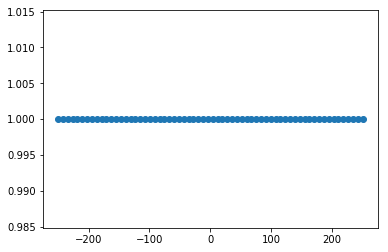

In [8]:
N = 64
max_pos = 250
Antenna_positions = 'Linear'

if Antenna_positions == 'Linear':
    pos = np.linspace(-max_pos,max_pos,N)
elif Antenna_positions == 'Random':
    pos = 2*max_pos*np.random.uniform(size=N)
elif Antenna_positions == 'Linear with Random':
    pos = np.linspace(-max_pos,max_pos,N)
    pos[0] = np.random.uniform(-max_pos,max_pos)
    pos[1] = np.random.uniform(-max_pos,max_pos)
    pos[2] = np.random.uniform(-max_pos,max_pos)
    
plt.scatter(pos, np.ones(64))
plt.show()

In [9]:
c = 299792458.0
N_BEAMS = 256
N_FREQ = 256
field_of_view_half_angle = 3.5
theta = np.linspace(-field_of_view_half_angle*np.pi/180.0, field_of_view_half_angle*np.pi/180.0, N_BEAMS)
# freq = np.linspace(1.49887,1.53, N_FREQ)

zero_pt = 0
gpu = 0
tot_channels = 2048
n_gpus = 8
bw_per_channel = (1.53 - 1.28)/tot_channels

freq = [1.53 - (zero_pt + gpu * tot_channels/(n_gpus-1) + i)* bw_per_channel for i in range(N_FREQ)]

form_beams_with_freq = range(256)#[0, 101,222, 255]
A = np.zeros((len(form_beams_with_freq), N_BEAMS, N), dtype=np.complex64)

for k, f in enumerate(form_beams_with_freq):
    wavelength = c/(freq[f]*1e9)
    for i in range(N_BEAMS):
        for j in range(N):
            A[k, i,j] = np.round(127.0*np.exp(-2.0j*np.pi*pos[j]*np.sin(theta[i])/wavelength))/127.0

In [17]:
eval_pts = 1024
# angles = np.linspace(-np.pi/2, np.pi/2, eval_pts)
angles = np.linspace(-field_of_view_half_angle*np.pi/180.0, field_of_view_half_angle*np.pi/180.0, eval_pts)
out = np.zeros((N_BEAMS, eval_pts))

for k, f in enumerate(form_beams_with_freq):
    print(k)
    wavelength = c/(freq[f]*1e9)
    for jj in range(len(angles)):
        signal = [np.round(7*np.exp(2*np.pi*1j*pos[i]*np.sin(angles[jj])/wavelength)) for i in range(N)]
        out[:,jj] += 8*np.real(np.dot(A[k,:,:], signal))**2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [18]:
# mpld3.disable_notebook()
%matplotlib tk
fig = plt.figure(figsize=(10,4))
fig.suptitle(Antenna_positions + " Locations")
ax = plt.subplot(121,projection='polar')
ax2 = plt.subplot(122)

for jj in range(256):
    ax.plot(angles, np.real(out[jj]))
    ax2.plot(angles*180/np.pi, np.real(out[jj]))
    
ax2.axis([-3.6, -3.4, -100, 2.0*max(out[0])])
ax2.set_xlabel("Angle [deg]")
ax2.set_ylabel("Response Amplitude")

plt.show()
# mpld3.enable_notebook()

In [12]:
fig = plt.figure(figsize= (8,4))
tr = 141
for k in range(4):
    ax = plt.subplot(tr)
    tr+=1
    ax.imshow(np.real(A[k]))
    ax.set_title("Freq = {0:.4g}".format(freq[form_beams_with_freq[k]]))
plt.show()

In [13]:
fig = plt.figure(figsize= (10,4))
plt.imshow(out.T)
plt.show()

In [20]:
# import os, sys
# import data
reload(data)
da = np.array(data.A)

vmx = max(np.max(data.A), np.max(out))

ax = plt.subplot(131)
ax.set_title("GPU")
ax.set_ylabel("Source Direction")
ax.set_xlabel("Beam Number")

ax2 = plt.subplot(132)
ax2.set_title("Python")
ax2.set_xlabel("Beam Number")
# ax2.colorbar()

ax3 = plt.subplot(133)
ax3.set_title("Difference")
b = np.abs((out.T - da)/out.T)
plt.suptitle("Beamformer Validation")
ax3.set_xlabel("Beam Number")

im = ax.imshow(da, vmin = 0, vmax = vmx)
im2 = ax2.imshow(out.T, vmin = 0, vmax = vmx)
im3 = ax3.imshow(b*100, vmin = 0, vmax = 1)

fig.colorbar(im2, ax = ax2)
fig.colorbar(im3, ax = ax3)

plt.show()
print(np.sqrt(np.sum(b**2)/(1024*256)))
print(np.mean(b)*100)

0.7500012864893203
75.00012569877404


In [35]:
print(da[528,127], out.T[528,127])

(3787950.0, 3787947.9296855829)


In [36]:
print(np.std(b), np.max(b))

(0.0, 1.0)


In [198]:
(out.T[526,128] - np.array(data.A)[526,128])/out.T[526,128]

-0.021868220855039949

In [203]:
ax = plt.subplot(121)
ax2 = plt.subplot(122)
_, bi, _ = ax.hist(x = np.log10(out.ravel()), bins=20, alpha = .7, log = True, label =  "Python")
ax.hist(x = np.log10(da.ravel()), bins=bi, alpha = .7, log = True, label = "GPU")
ax.set_title("Python vs GPU Image Histograms")
ax.set_xlabel("$\log_{10}$(Pixel Intensity)")
ax.legend()

ax2.hist(x = b.ravel(), bins=20, alpha = .7, log = True)
ax2.set_title("Errors")
ax2.set_xlabel("% error")

plt.suptitle("Comparison of Beamformer Results")
plt.show()